In [2]:
#本文件主要用来进行特征工程，
#总的步骤是，先对特征进行处理，再进行编码以便建模
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from decimal import *
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification



ads = pd.read_csv('./round1_ijcai_18_train_20180301.csv')

In [3]:
pd.set_option('display.max_columns', None)


In [4]:
#####1. 删除instance_id, item_id, user_id, context_id,shop_id 
ads = ads.drop(['instance_id', 'item_id', 'user_id', 'context_id', 'shop_id'])   #仅需使用一次



ValueError: labels ['instance_id' 'item_id' 'user_id' 'context_id' 'shop_id'] not contained in axis

In [52]:
#####2. 根据相关性，有些特征之间相关性很大，但是在这里不直接删除，而是通过比较重要性再删除一些
########    random forest 和 xgboost 都可以对各feature的importance进行比较， 这里就不手动删除了

In [53]:
#优先顺序：
"""
解决category，property，和predict_category_property问题

引入三个新特征

之后再使用bin提升，以及bin的再优化
"""

'\n解决category，property，和predict_category_property问题\n\n引入三个新特征\n\n之后再使用bin提升，以及bin的再优化\n'

In [ ]:
######3. timestamp的处理：去掉日期，以小时为单位进行map，之后进行bin

def cvt_time(str1):
    hour = int(datetime.datetime.fromtimestamp(int(str1)).strftime('%H'))
#     minute = int(datetime.datetime.fromtimestamp(int(str1)).strftime('%M'))
    return hour

#2018-09-17 2018-09-24  一共8天的数据

ads['context_timestamp'] = ads['context_timestamp'].apply(cvt_time)
# ads['context_timestamp'].unique()

context_timestamp
0     24638
1     27463
2     27176
3     26816
4     24520
5     23407
6     25293
7     33621
8     40998
9     42662
10    35865
11    21107
12    10772
13     4474
14     2463
15     1885
16     1561
17     2332
18     5387
19    11003
20    15470
21    19889
22    24292
23    24053
dtype: int64
count       24.000000
mean     19881.125000
std      12496.515735
min       1561.000000
25%       9425.750000
50%      23730.000000
75%      26906.000000
max      42662.000000
Name: times, dtype: float64


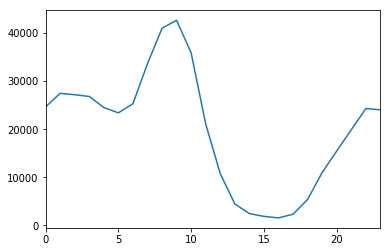

0
Number:24638, percentage of total:0.0516
0.0231
0.9769
1
Number:27463, percentage of total:0.0576
0.0186
0.9814
2
Number:27176, percentage of total:0.0570
0.0194
0.9806
3
Number:26816, percentage of total:0.0562
0.0182
0.9818
4
Number:24520, percentage of total:0.0514
0.0177
0.9823
5
Number:23407, percentage of total:0.0491
0.0181
0.9819
6
Number:25293, percentage of total:0.0530
0.0196
0.9804
7
Number:33621, percentage of total:0.0705
0.0195
0.9805
8
Number:40998, percentage of total:0.0859
0.0187
0.9813
9
Number:42662, percentage of total:0.0894
0.0158
0.9842
10
Number:35865, percentage of total:0.0752
0.0130
0.9870
11
Number:21107, percentage of total:0.0442
0.0114
0.9886
12
Number:10772, percentage of total:0.0226
0.0175
0.9825
13
Number:4474, percentage of total:0.0094
0.0177
0.9823
14
Number:2463, percentage of total:0.0052
0.0223
0.9777
15
Number:1885, percentage of total:0.0040
0.0154
0.9846
16
Number:1561, percentage of total:0.0033
0.0186
0.9814
17
Number:2332, percentage o

In [44]:
import matplotlib.pyplot as plt

def inner_dist(df, attr):
    
    for i, temp in enumerate(list(df[attr])):

        yes = 0
        no = 0
        for index, row in ads.iterrows():
            if temp == row[attr] and row['is_trade'] == 1:
                yes = yes +1
            if temp == row[attr] and row['is_trade'] == 0:
                no = no +1
        print(temp)
        print('Number:%d, percentage of total:%0.4f'%(
            (yes+no), (yes+no)/ads.shape[0]))
        print(format((yes/(yes+no)), '0.4f'))  
        print(format((no/(yes+no)), '0.4f'))

gp2 = ads.groupby(by='context_timestamp')
newdf2=gp2.size()
print(newdf2)
newdf2 = newdf2.reset_index(name='times') 
print(newdf2['times'].describe())

newdf2['times'].plot()
plt.show()
inner_dist(newdf2, 'context_timestamp')   

In [55]:
#好的bin操作是根据分布来，而不是根据数量来，
#如果分布相差不大，可以就近bin，毕竟一来可以降维，二来类别之间数量平衡有利于树模型准确

#数量太小则概率不可信
#根据以上发现，最小0.9740,最大0.9886,相差很小，所以就近bin;
#再bin操作，因为除了中间一段其他分布比较均匀，我们决定：1,2,3,4,5,。。。11,12,13-18,19-20,21,22,23  并且加上1


def bin_time(num):
    if num in [13,14,15,16,17,18]:
        num=14
    elif num in[19,20]:
        num=15
    elif num in [21, 22,23]:
        num =num-5
    else:
        num = num +1
    return num

ads['context_timestamp'] = ads['context_timestamp'].apply(bin_time)
ads['context_timestamp'].unique()

array([17,  1, 14,  8, 12, 11,  5,  6, 18,  3, 13,  7,  4, 10, 15,  9, 16,
        2])

In [15]:
####4.解决category，property，和predict_category_property问题
#分开predict_category_property问题
i=0
for index, row in ads[['predict_category_property']].iterrows():
    if '7908382889764677758' in row['predict_category_property']:
        i+=1
    if i <100:
        print(row['predict_category_property'])
i   #467819几乎每一行都有，也就是20,30%以上至少的

#对于预测category为7908382889764677758，如果后面是-1, 直接扔掉，没有任何意义; 
#对于不是1的， 可以做聚类映射到其他子类别上面--------这是特征工程一个方向
#但是目前来讲，直接全部扔掉

5799347067982556520:-1;509660095530134768:-1;5755694407684602296:-1;8277336076276184272:9148482949976129397;7908382889764677758:-1
5799347067982556520:9172976955054793469;7908382889764677758:1787573075717641245,9172976955054793469,5195139481388729954,4621934203383159480,9148482949976129397
5799347067982556520:5131280576272319091;7258015885215914736:5131280576272319091;7908382889764677758:5131280576272319091
509660095530134768:-1;5799347067982556520:-1;7908382889764677758:1787573075717641245,9148482949976129397;7492960463130085436:9148482949976129397;1950314698730389427:8218883658021718578,6641007758333551406,3749629542652371225,4038060334629950706,6165347051143749031,360508730875480086,9148482949976129397
5799347067982556520:9172976955054793469;7908382889764677758:9172976955054793469
5799347067982556520:9172976955054793469;8710739180200009128:-1;5755694407684602296:-1;4879721024980945592:5131280576272319091;7908382889764677758:9172976955054793469,5131280576272319091
2011981573061447208

467819

In [6]:
df = ads['predict_category_property'].str.split(';',expand=True)
# df
#对于每个row， 将全部category集中（删除母类7908382889764677758）;-----这一步这一次完成
#对于每个row， 将全部property集中， 这样可以将property与千面property进行nlp相关性检查，创造新特征----这是下一步改进
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,5799347067982556520:-1,509660095530134768:-1,5755694407684602296:-1,8277336076276184272:9148482949976129397,7908382889764677758:-1,None,None,None,None,None,None,None,None,None
1,5799347067982556520:9172976955054793469,"7908382889764677758:1787573075717641245,917297...",None,None,None,None,None,None,None,None,None,None,None,None
2,5799347067982556520:5131280576272319091,7258015885215914736:5131280576272319091,7908382889764677758:5131280576272319091,None,None,None,None,None,None,None,None,None,None,None
3,509660095530134768:-1,5799347067982556520:-1,"7908382889764677758:1787573075717641245,914848...",7492960463130085436:9148482949976129397,"1950314698730389427:8218883658021718578,664100...",None,None,None,None,None,None,None,None,None
4,5799347067982556520:9172976955054793469,7908382889764677758:9172976955054793469,None,None,None,None,None,None,None,None,None,None,None,None
5,5799347067982556520:9172976955054793469,8710739180200009128:-1,5755694407684602296:-1,4879721024980945592:5131280576272319091,"7908382889764677758:9172976955054793469,513128...",None,None,None,None,None,None,None,None,None
6,2011981573061447208:7199361004668592209,8277336076276184272:7199361004668592209,5755694407684602296:-1,7908382889764677758:7199361004668592209,7447522129235776380:-1,8190716055759423915:-1,None,None,None,None,None,None,None,None
7,2011981573061447208:7199361004668592209,8277336076276184272:7199361004668592209,5755694407684602296:-1,7908382889764677758:7199361004668592209,7447522129235776380:-1,8190716055759423915:-1,None,None,None,None,None,None,None,None
8,5755694407684602296:-1,5799347067982556520:-1,7908382889764677758:1354874066266948599,8710739180200009128:-1,509660095530134768:-1,8277336076276184272:-1,None,None,None,None,None,None,None,None
9,8277336076276184272:820214312075361939,509660095530134768:-1,"5799347067982556520:938942550188415640,9148482...",5755694407684602296:-1,3203673979138763595:-1,7908382889764677758:-1,None,None,None,None,None,None,None,None


In [7]:
#进行摘取category工作，
def cate_father(str1):
    if str1 == '7908382889764677758':
        return None
    else:
        return str1
    
temp_0 = df[0].str.split(':',expand=True)[0].apply(cate_father)
temp_1 = df[1].str.split(':',expand=True)[0].apply(cate_father)
temp_2 = df[2].str.split(':',expand=True)[0].apply(cate_father)
temp_3 = df[3].str.split(':',expand=True)[0].apply(cate_father)
temp_4 = df[4].str.split(':',expand=True)[0].apply(cate_father)
temp_5 = df[5].str.split(':',expand=True)[0].apply(cate_father)
temp_6 = df[6].str.split(':',expand=True)[0].apply(cate_father)
temp_7 = df[7].str.split(':',expand=True)[0].apply(cate_father)
temp_8 = df[8].str.split(':',expand=True)[0].apply(cate_father)
temp_9 = df[9].str.split(':',expand=True)[0].apply(cate_father)
temp_10 = df[10].str.split(':',expand=True)[0].apply(cate_father)
temp_11 = df[11].str.split(':',expand=True)[0].apply(cate_father)
temp_12 = df[12].str.split(':',expand=True)[0].apply(cate_father)
temp_13 = df[13].str.split(':',expand=True)[0].apply(cate_father)

In [71]:
category = pd.concat([temp_0, temp_1, temp_2, temp_3, temp_4,temp_5,temp_6,
                      temp_7,temp_8,temp_9,temp_10,temp_11,temp_12,temp_13], axis=1)
category.columns = ['pred_cat_0','pred_cat_1','pred_cat_2','pred_cat_3','pred_cat_4','pred_cat_5',
                               'pred_cat_6','pred_cat_7','pred_cat_8','pred_cat_9','pred_cat_10',
                               'pred_cat_11','pred_cat_12','pred_cat_13']
ads = pd.concat([ads, category], axis=1)
del ads['predict_category_property']

In [74]:
ads.head(2)   #这个feature处理要进行到哪一步才算好？？？

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade,pred_cat_0,pred_cat_1,pred_cat_2,pred_cat_3,pred_cat_4,pred_cat_5,pred_cat_6,pred_cat_7,pred_cat_8,pred_cat_9,pred_cat_10,pred_cat_11,pred_cat_12,pred_cat_13
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,1,1003,2005,3003,282924576738839389,22,4006,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0,5799347067982556520,509660095530134768,5755694407684602296,8277336076276184272,None,None,None,None,None,None,None,None,None,None
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,0,1002,2005,3006,4007979028023783431,0,4001,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0,5799347067982556520,None,None,None,None,None,None,None,None,None,None,None,None,None


In [76]:
######4.bin操作， 根据分布将小的分类进行合并，下面这些attribute均进行合并
#item_city_id 可以将来做聚类， 现在把所有128个进行onehot
#item_price_level   0-4,5,6,...,8,9-17(9,10,11,17)
#item_sales_level  -1,1-5,6,7,...,14,15-17
#item_collected_level   0-2, 3-5, 6-8, 9, 10, ...,15, 16-17
#item_pv_level     0-6, 7-13,14,15,17,18,19,20,21
#user字段不需要

#context_page_id  4001, 4002, 4003,。。。4008,4009-4020

#shop_review_num_level   0-8,9,...21,22-25
#shop_review_positive_rate   =<0.95, 0.96-0.98, 0.99-0.999,0.999-1
#shop_star_level    4999-5005,5006,...,5018, 5019-5020

#这些bin的操作是将来可以提升的地方


In [80]:
####5. other bin operations   #这里还可以更精确
#shop_score_service  
#shop_score_delivery
#shop_score_description 

def bin_shop_score_service(num):
    if num <= 0.96:
        return 1
    elif num <= 0.975:
        return 2
    elif num <= 0.99:
        return 3
    else:
        return 4
ads['shop_score_service'] = ads['shop_score_service'].apply(bin_shop_score_service)

count    477147.000000
mean          2.286612
std           0.628893
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: shop_score_service, dtype: float64

In [82]:
#shop_score_delivery
def bin_shop_score_delivery(num):
    if num <= 0.96:
        return 1
    elif num <= 0.97:
        return 2
    elif num <= 0.9:
        return 3
    else:
        return 4
ads['shop_score_delivery'] = ads['shop_score_delivery'].apply(bin_shop_score_delivery)

In [84]:
#shop_score_description
def bin_shop_score_description(num):
    if num <= 0.97:
        return 1
    elif num <= 0.98:
        return 2
    elif num <= 0.99:
        return 3
    else:
        return 4
ads['shop_score_description'] = ads['shop_score_description'].apply(bin_shop_score_description)

In [91]:
#ads.to_csv('./fe_train.csv', index=False)

In [ ]:
####5. Data balancing
#先随机采样减小计算复杂度
chosen_idx = np.random.choice(len(ads), replace=False, size=1000)
sample_raw = ads.iloc[chosen_idx]

rm_col = ['instance_id', 'item_id','user_id','context_id',"item_category_list","item_property_list","predict_category_property"]
sample_raw = sample_raw.drop(rm_col, axis=1)

# sample_raw.item_category_list = sample_raw.item_category_list.str.split(";")
# sample_raw.item_property_list = sample_raw.item_property_list.str.split(";")
# sample_raw.predict_category_property  = sample_raw.predict_category_property.str.split(";")

In [1]:
import pandas as pd
